# EFC2: MNIST CNN Classifier

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

# 0. Dataset and Description

**Name:**  MNIST  
**Description:** this notebook uses the MNIST database to perform an Multilayer Perceptron (MLP) classifier and a Convolutional Neural Network (CNN) with the aim of image classification of handwritten digits. We use the validation set to choose the hyperparameters.

# 1. Libraries and packages

## 1.1 Install packages

In [0]:
!pip install -q    \
    numpy          \
    sklearn        \
    matplotlib     \
    tensorflow      \
    tensorflow-determinism

## 1.2 Import libraries

In [0]:
#-------------------------------------------------
# general
#-------------------
import numpy as np
import tensorflow as tf
import os
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 2. Check Device

In [0]:
# choose between CPU and GPU
device = tf.device('/cpu:0')
if tf.config.list_physical_devices('GPU'):
    device = tf.device('/device:GPU:0')
#    device_model = torch.cuda.get_device_name(0)
#    device_memory = torch.cuda.get_device_properties(device).total_memory / 1e9
    device_number = len(tf.config.experimental.list_physical_devices('GPU'))
    #----------------------------
    #from tensorflow.python.client import device_lib
    #device_lib.list_local_devices()
    #----------------------------
    print('Device: gpu')
    #print('GPU model:', device_model)
    #print('GPU memory: {0:.2f} GB'.format(device_memory))
    print("GPUs available: ", device_number)
    print('#-------------------')
print('CPU cores:', cpu_count())

Device: gpu
GPUs available:  1
#-------------------
CPU cores: 2


# 3. CNN approach

## 3.1 Professor's reference implementation

Just like the MLP approach, the following code is the professor's suggestion with the same modifications applied before.

In [0]:
def cnn_train_professor(device, seed=42):
    with device:
        # define RNG seed
        np.random.seed(seed)
        tf.random.set_seed(seed)
        #----------------------------
        # getting the dataset
        mnist = tf.keras.datasets.mnist
        (x_train, y_train),(x_test, y_test) = mnist.load_data()
        # reshape to be [samples][width][height][pixels]
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
        x_train, x_test = x_train / 255.0, x_test / 255.0
        #----------------------------
        # defining the model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        #----------------------------
        # defining the model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        #----------------------------
        # training
        model.fit(x_train, y_train, epochs=5, verbose=0)
        #----------------------------
        # evaluation
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        #----------------------------
        # saving the model and weights
        #model_json = model.to_json()
        #json_file = open("model_CNN.json", "w")
        #json_file.write(model_json)
        #json_file.close()
        #model.save_weights("model_CNN.h5")
        #print("Model saved to disk")
        #os.getcwd()
        #----------------------------
        print('seed = ', str(seed), '; ',
            'loss = ', '{0:.4f}'.format(loss), '; ',
            'accuracy = ', '{0:.4f}'.format(accuracy), sep='')
        #----------------------------
        return loss, accuracy

Running the model 10 times to get an average loss and accuracy

In [0]:
seeds = range(10)
loss_his_cnn_prof = []
acc_his_cnn_prof = []
#----------------------------
for seed in seeds:
    loss, acc = cnn_train_professor(device, seed=seed)
    # append both loss and accuracy in a list for comparison
    loss_his_cnn_prof.append(loss)
    acc_his_cnn_prof.append(acc)

seed = 0; loss = 0.0335; accuracy = 0.9891
seed = 1; loss = 0.0316; accuracy = 0.9904
seed = 2; loss = 0.0338; accuracy = 0.9894
seed = 3; loss = 0.0247; accuracy = 0.9920
seed = 4; loss = 0.0305; accuracy = 0.9909
seed = 5; loss = 0.0314; accuracy = 0.9908
seed = 6; loss = 0.0356; accuracy = 0.9897
seed = 7; loss = 0.0309; accuracy = 0.9906
seed = 8; loss = 0.0305; accuracy = 0.9911
seed = 9; loss = 0.0281; accuracy = 0.9911


Getting the average loss and accuracy of the 10 executions

In [0]:
print('Loss average = {0:.4f}'.format(np.mean(loss_his_cnn_prof)))
print('Accuracy average = {0:.4f}'.format(np.mean(acc_his_cnn_prof)))

Loss average = 0.0310
Accuracy average = 0.9905


## 3.2 My implementation

In [0]:
def cnn_train(device, seed=42, verbose=False):
    with device:
        # define RNG seed
        np.random.seed(seed)
        tf.random.set_seed(seed)
        #----------------------------
        # getting the dataset
        mnist = tf.keras.datasets.mnist
        (x_train_raw, y_train_raw),(x_test, y_test) = mnist.load_data()
        # reshape to be [samples][width][height][pixels]
        x_train_raw = x_train_raw.reshape(x_train_raw.shape[0], 28, 28, 1)
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
        x_train_raw, x_test = x_train_raw / 255.0, x_test / 255.0
        #----------------------------
        # train-dev split
        x_train, x_dev, y_train, y_dev = train_test_split(
            x_train_raw,
            y_train_raw,
            test_size=0.2,
            random_state=seed,
            shuffle=True)
        #----------------------------
        # defining the model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.50))
        #--------------
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.50))
        #--------------
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        #----------------------------
        # early-stopping
        callback_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5,
            mode='min',
            verbose=verbose,
            restore_best_weights=True
        )
        #----------------------------
        # optmizer
        opt_adam = tf.keras.optimizers.Adam(learning_rate=5e-4)
        #----------------------------
        # learning rate schedule
        # lr = 0.0005 for the first 20 epochs and decreases exponentially after that
        def scheduler(epoch):
            if epoch < 20:
                return 0.0005
            else:
                return 0.0005 * tf.math.exp(0.1 * (20 - epoch))
        callback_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
        #----------------------------
        # defining the model
        model.compile(
            optimizer=opt_adam,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        #----------------------------
        # training
        model.fit(x_train, y_train, 
            epochs=100, 
            batch_size=64,
            callbacks=[callback_stop, callback_schedule], 
            validation_data=(x_dev, y_dev),
            verbose=verbose,
        )
        #----------------------------
        # evaluation in test set
        loss, accuracy = model.evaluate(x_test, y_test, verbose=verbose)
        # evaluation in training set
        _, accuracy_train = model.evaluate(x_train_raw, y_train_raw, verbose=verbose)
        #----------------------------
        # saving the model and weights
        #model_json = model.to_json()
        #json_file = open("model_CNN.json", "w")
        #json_file.write(model_json)
        #json_file.close()
        #model.save_weights("model_CNN.h5")
        #print("Model saved to disk")
        #os.getcwd()
        #----------------------------
        print('seed = ', str(seed), '; ',
            'epochs = ', str(callback_stop.stopped_epoch - callback_stop.patience + 1), '; ', 
            'loss = ', '{0:.4f}'.format(loss), '; ',
            'accuracy = ', '{0:.4f}'.format(accuracy), '; '
            'accuracy train = ', '{0:.4f}'.format(accuracy_train), sep='')
        #----------------------------
        return loss, accuracy, accuracy_train


Running the model 10 times to get an average loss and accuracy

In [0]:
seeds = range(10)
loss_his_cnn = []
acc_his_cnn = []
acc_his_cnn_train = []
#----------------------------
for seed in seeds:
    loss, acc, acc_train = cnn_train(device, seed=seed)
    # append both loss and accuracy in a list for comparison
    loss_his_cnn.append(loss)
    acc_his_cnn.append(acc)
    acc_his_cnn_train.append(acc_train)

seed = 0; epochs = 29; loss = 0.0205; accuracy = 0.9927; accuracy train = 0.9961
seed = 1; epochs = 34; loss = 0.0225; accuracy = 0.9928; accuracy train = 0.9966
seed = 2; epochs = 29; loss = 0.0218; accuracy = 0.9932; accuracy train = 0.9961
seed = 3; epochs = 46; loss = 0.0180; accuracy = 0.9939; accuracy train = 0.9969
seed = 4; epochs = 29; loss = 0.0189; accuracy = 0.9926; accuracy train = 0.9962
seed = 5; epochs = 50; loss = 0.0193; accuracy = 0.9934; accuracy train = 0.9971
seed = 6; epochs = 39; loss = 0.0190; accuracy = 0.9938; accuracy train = 0.9968
seed = 7; epochs = 36; loss = 0.0211; accuracy = 0.9931; accuracy train = 0.9966
seed = 8; epochs = 31; loss = 0.0206; accuracy = 0.9934; accuracy train = 0.9962
seed = 9; epochs = 30; loss = 0.0212; accuracy = 0.9922; accuracy train = 0.9963


Getting the average loss and accuracy of the 10 executions

In [0]:
print('Loss average = {0:.4f}'.format(np.mean(loss_his_cnn)))
print('Accuracy average = {0:.4f}'.format(np.mean(acc_his_cnn)))
print('Accuracy average (training set) = {0:.4f}'.format(np.mean(acc_his_cnn_train)))

Loss average = 0.0203
Accuracy average = 0.9931
Accuracy average (training set) = 0.9965


## 3.3 Results comparison

The next table compares the accuracy metric on the test set of the two implementations: the professor's reference implementation and the developed implementation.

| seed | reference acc | developed acc | dev. acc (train) |
|:---: | :-----------: | :-----------: | :--------------: |
|   0  |    0.9891     |     0.9927    |      0.9961      |
|   1  |    0.9904     |     0.9928    |      0.9966      |
|   2  |    0.9894     |     0.9932    |      0.9961      |
|   3  |    0.9920     |     0.9939    |      0.9969      |
|   4  |    0.9909     |     0.9926    |      0.9962      |
|   5  |    0.9908     |     0.9934    |      0.9971      |
|   6  |    0.9897     |     0.9938    |      0.9968      |
|   7  |    0.9906     |     0.9931    |      0.9966      |
|   8  |    0.9911     |     0.9934    |      0.9962      |
|   9  |    0.9911     |     0.9922    |      0.9963      |

The next table shows the mean of 10 trainings of each implementation's accuracy:

|      | reference acc | developed acc | dev. acc (train) |
|:---: | :-----------: | :-----------: | :--------------: |
| mean |    0.9905     |     0.9931    |      0.9965      |

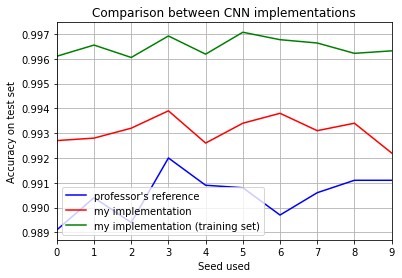

In [0]:
# plot both implementation's accuracy for different seeds
plt.plot(acc_his_cnn_prof, label='professor\'s reference', color='blue')
plt.plot(acc_his_cnn, label='my implementation', color='red')
plt.plot(acc_his_cnn_train, label='my implementation (training set)', color='green')
#-------------------------------------------------
# axis label
plt.xlabel('Seed used')
plt.ylabel('Accuracy on test set')
# title
plt.title('Comparison between CNN implementations')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

## 3.4 How I achieved my final network setup

### 3.4.1 Modifications


Obs.: The accuracy reported was obtained with the test set after the training. The random seed used for all experiments was 42.

___

**1.** The first execution was done without any changes. Accuracy = 0.9902.

**2.** Increased dropout from 25% to 50% after second convolutional layer. Final accuracy = 0.9912.

**3.** Added max pooling layer and dropout of 50% after first convolutional layer. Final accuracy = 0.9908.

**4.** Increased number of epochs from 5 to 10. Final accuracy = 0.9914.

**5.** Split the trainig set (60,000 samples) in training (48,000 samples) and development set (12,000 samples). Added early-stopping with patience of 5 epochs. Final accuracy = 0.9928.

**6.** Added a schedule to decrease the learning rate exponentially after 20 epochs. Final accuracy = 0.9934.

**7.** Increased batch size to 64. Final accuracy = 0.9940.

### 3.4.2 References

The same page from Yann LeCun cited before [1] has also results considering convolutional neural networks. However, almost all of the ones with the best results use some kind of distortion (elastic, affine) or use unsupervised pretraining.

This way, the modifications were empirical and based on a 'trial and error' approach, considering some well known practices (ex: using development set, early-stopping, learning rate schedule) and trying not to change the network architecture (kernel size, layers, etc).

___

[1] http://yann.lecun.com/exdb/mnist/

# 4. Comparison between different approaches

The next table compares the accuracy on the test set for the following approaches:
 - Linear Classifier (EFC1, Q1)
 - Extreme Learning Machine (EFC2, Q2)
 - Multilayer Perceptron (EFC2, Q3)
 - Convolutional Neural Network (EFC2, Q4)

| approach | accuracy test | accuracy train |
|:-------: | :-----------: | :------------: |
|  Linear  |    0.8647     |     0.8575     |
|   ELM    |    0.9194     |     0.9175     |
|   MLP    |    0.9834     |     0.9960     |
|   CNN    |    0.9929     |     0.9965     |

Briefly comments explaining the performance improvement of each approach:
- **Linear:** Base model. Performance level achieved due to closed solution that minimizes the MSE and also due to regularization.

- **ELM:** Improvements achieved because of the non-linearity added to the model (ReLU units). Regularization via ridge regression also used.

- **MLP:** Improvements achieved because now we are training a neural network. Instead of choosing random weights values (like in ELM), now the model adapt the weights aiming the minimization of the error at the output. This is done via error backpropagation. Regularization is also used here (early stopping, dropout).

- **CNN:** Improvements achieved because of the convolutional layers. The MLP approach implies that the network will have good results only if the pixels of the new input have similar values to those ones seen during the training. The convolutional layers are able to find features anywhere in the image now, and not to those positions specifically found during the training (translational invariance). The pooling layers are also important to help the network to find a feature in different positions of the image. Finally, the same regularization of MLP also takes place here.

# End of the notebook